In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [17]:
print(os.path.exists('02 - cleaned_household_power_consumption.csv'))

True


In [18]:
df = pd.read_csv('02 - cleaned_household_power_consumption.csv', index_col=0, parse_dates=True)

## Time Series Parsing & Resampling

In this step the minute-level household energy consumption data is resampled into hourly and daily intervals to prepare data for short term forecasting. 

In [4]:
# Resample hourly data

hourly_df = df.resample('h').mean() # h -> Hourly Resampling, mean -> average energy use per hour
hourly_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0


In [5]:
# Resample daily data

daily_df = df.resample('d').mean() # d -> Daily Resampling, mean -> average energy use per hour
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2007-01-01,1.909031,0.102893,240.128979,7.916944,0.000000,0.244444,4.083333
2007-01-02,0.881414,0.132182,241.943778,3.714028,0.000000,0.241667,4.556944
2007-01-03,0.704204,0.136617,243.557090,3.014028,0.000000,0.238889,3.309028
2007-01-04,2.263481,0.140487,239.750299,9.478194,0.729861,5.275694,7.566667
2007-01-05,1.884281,0.120246,240.495764,7.885139,1.029861,0.263194,5.279167


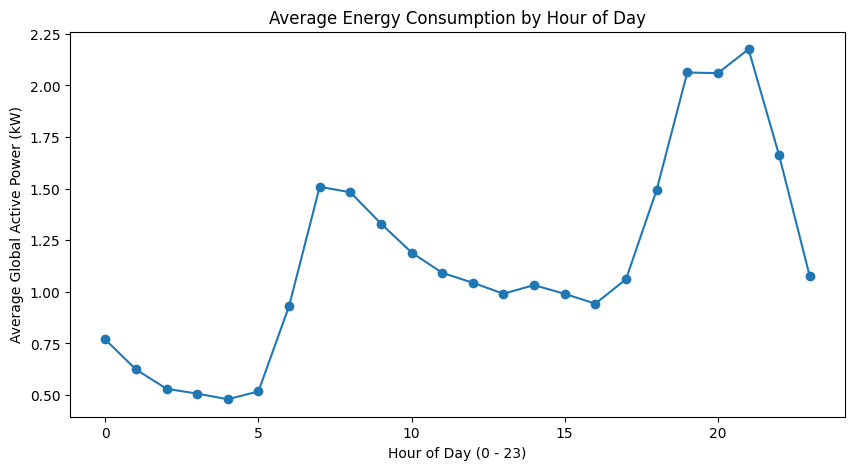

In [6]:
# Visualizing peak hours of energy consumption

hourly_df['hour'] = hourly_df.index.hour # Extract hour of day

hourly_pattern = hourly_df.groupby('hour')['Global_active_power'].mean() # Compute average usage per hour

hourly_pattern.plot(marker='o', figsize=(10, 5), title="Average Energy Consumption by Hour of Day", xlabel="Hour of Day (0 - 23)", ylabel="Average Global Active Power (kW)")
plt.show()

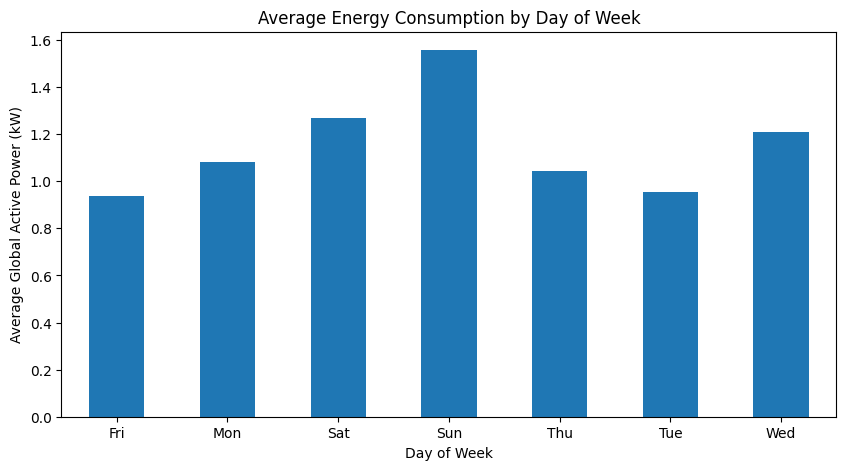

In [8]:
# Visualizing peak days of energy consumption

daily_df['day_of_week'] = daily_df.index.dayofweek # Extract day of week (0=Monday, 6=Sunday)

# Map day numbers to names
day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
daily_df['day_name'] = daily_df['day_of_week'].map(day_map)

daily_pattern = daily_df.groupby('day_name')['Global_active_power'].mean() # Average usage by day

daily_pattern.plot(kind='bar', figsize=(10, 5), title="Average Energy Consumption by Day of Week", xlabel="Day of Week", ylabel="Average Global Active Power (kW)")
plt.xticks(rotation=0)
plt.show()

## Time-Based Feature Engineering

In this step time-based features are extracted from the datetime index to capture repeating temporal patterns in household energy consumption. These engineered features will later be used by machine-learning models (XGboost in our case) to improve forecasting performance.

In [9]:
features_df = hourly_df.copy()

In [10]:
features_df['hour'] = features_df.index.hour # Extract hour of day (0–23)

In [11]:
features_df['day_of_week'] = features_df.index.dayofweek # Extract day of week (0 = Monday, 6 = Sunday)

In [12]:
features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int) # weekend indicator (1 = weekend, 0 = weekday)

In [13]:
features_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,is_weekend
DateTime,,,,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0,0,0,0
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0,1,0,0
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0,2,0,0
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0,3,0,0
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0,4,0,0


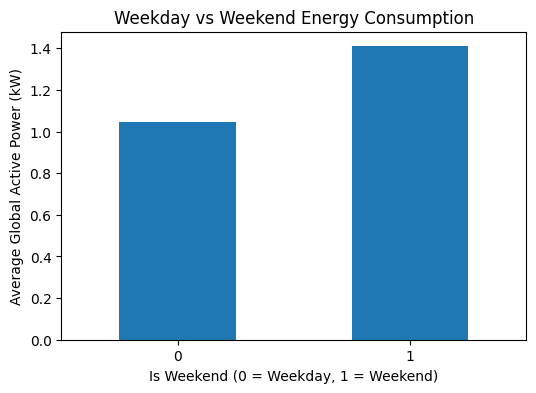

In [14]:
# Average energy usage by weekend indicator
features_df.groupby('is_weekend')['Global_active_power'].mean().plot(
    kind='bar',
    figsize=(6, 4),
    title="Weekday vs Weekend Energy Consumption",
    xlabel="Is Weekend (0 = Weekday, 1 = Weekend)",
    ylabel="Average Global Active Power (kW)"
)
plt.xticks(rotation=0)
plt.show()

In [16]:
features_df.to_csv('03 - hourly_features_dataset.csv')